In [1]:
import pyslha #For interacting with SLHA files
import subprocess #Running command
import scipy #Numeric Library
import sympy #symbolic computation - might not be used here
from scipy import optimize
from sympy import *
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
%matplotlib inline
from numpy import logspace, linspace 
from itertools import product
import glob #filehandling
from subprocess import call
import os
#Path to modified verison of Softsusy 
SoftSUSY_PATH = 'softsusy-4.1.4-Garon/softpoint.x' 
mHiggs = 125 #Higgs Mass for paper
print ("hello")

hello


In [10]:
def slhaPoint(model='FGMCaseB0', mMess=1e12, tanBeta=10, beta2=0, beta3=0, betaeps=0.0, thetavev=0, 
              outputFile='test.slha', Lambda=1e6, mode='point', LambdaGuess=6e5):
    '''
    Code for interacting with SoftSUSY and running the models we've been looking at.
    The models themselves are encoded in a modified version of it. 
    This may seem like extra work because it accepts an arbitrary SLHA2 file, but since our models
    include fitted parameters, like the Yukawa couplings, we need to use the values that it calculates
    during the running. 
    The parameters:
    model - the name of the model in SoftSUSY
    mMess - the messenger scale
    tanBeta - tan beta
    beta2 - beta2
    beta3 - beta3
    outputFile - the name of the file to write to (this step could conceivably be removed by writing the console output to memory)
    Lambda - F/M
    mode - There are 3 modes
        'Fit' - uses Newton's method from a few different starting points
        'Bisect' - uses a Bisection routine from a few different brackets
        'Point' - runs a single point
    LambdaGuess - a guess at the value of Lambda for the 'Fit' mode.
    '''
    
    dataline ="./{} {} --mMess={} --LAMBDA={} --tanBeta={} --beta2={} --beta3={} --thetavev={} --betaeps={} --cgrav=1. > {}"
    startingPoints = [LambdaGuess, 1e6, 5e6, 6e4]
    bracket, l = [(2,5), (5,10), (2,10), (2,8), (4,8), (1,3), (8,12)], 0
    
    #a helper functin that takes a value of x (Lambda), runs it (line 2) and then reads in the Higgs mass
    def f(x):
        string = dataline.format(SoftSUSY_PATH, model, str(mMess), str(x), 
                                 str(tanBeta), str(beta2), str(beta3), str(thetavev), str(betaeps), outputFile)
        subprocess.Popen(string, stdout=None, shell=True).wait()
        #print ("the string is ")
        print (string)
        return pyslha.read(outputFile).blocks['MASS'][25] - mHiggs
    
    if mode == 'Fit':
        #print ('in fit')
        a, i = 0, 0
        while((a <= 0) & (i < len(startingPoints))):
            try:
                #Newton's method
                print ("in try")
                a = optimize.newton(f, startingPoints[i], tol=1e-4)
                print ("in newton")
                print (a)
            except:
                print ('got excepted')
                a = 0
                i += 1
        if (a>0):
            data = pyslha.read(outputFile)
            #accept or reject based on the deviation from the Higgs mass
            if (-0.1 < data.blocks['MASS'][25]-125 < 0.1) :
                try:
                    #if there's something in this location SoftSUSY has an error.
                    data.blocks['SPINFO'][3]
                except:
                    return data
    elif mode == 'Bisect':
        for k in bracket:
            print(k)
            try:
                l = optimize.brentq(f, k[0] * 1e5, k[1] * 1e5, rtol=1e-4)
                if l:
                    break
            except:
                #print('nada')
                continue
        if l:
            data = pyslha.read(outputFile)
            print(data.blocks['MASS'][25])
            if (-0.25 < data.blocks['MASS'][25]-125 < 0.25) :
                try:
                    data.blocks['SPINFO'][3]
                except:
                    return data
            else:
                #the bisection routine tends to get things close but not exact, so it calls 'Fit' if it's close.
                return slhaPoint(model, mMess, tanBeta, beta2, beta3,\
                              outputFile, Lambda, 'Fit', LambdaGuess=data.blocks['MINPAR'][1])
        else:
            #just to be safe (but is probably unneded)
            return slhaPoint(model, mMess, tanBeta, beta2, beta3,\
                              outputFile, Lambda, 'Fit')
    else:
        #runs a single point
        try:
            f(Lambda)
            data = pyslha.read(outputFile)
            return data.blocks['MASS'][25], data
        except (pyslha.ParseError, RuntimeError):
            return "No Solution", 0

In [11]:
gridmMess = logspace(6,16,41)
results = []
for i in gridmMess:
    results.append(slhaPoint(model='FGMCaseB2',mMess=i,mode='Point')[0])

./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1000000.0 --LAMBDA=1000000.0 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=1778279.410038923 --LAMBDA=1000000.0 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=3162277.6601683795 --LAMBDA=1000000.0 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=5623413.251903491 --LAMBDA=1000000.0 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=10000000.0 --LAMBDA=1000000.0 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.0 --cgrav=1. > test.slha
./softsusy-4.1.4-Garon/softpoint.x FGMCaseB2 --mMess=17782794.100389227 --LAMBDA=1000000.0 --tanBeta=10 --beta2=0 --beta3=0 --thetavev=0 --betaeps=0.

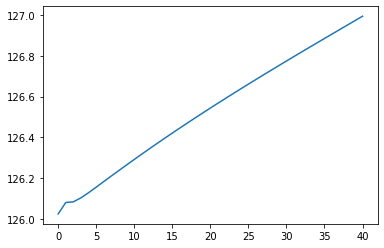

In [12]:
plt.plot(results)

In [8]:
print(results)

[126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123, 126.994123]
